In [278]:
#Import modules
import random 
import numpy as np
import pandas as pd 
import uuid
import matplotlib.pyplot as plt 

In [279]:
# Create default functions
def DefaultChoose(*argv, **kwargs):
    return bool(random.getrandbits(1))
    
def DefaultLearn(*argv, **kwargs):
    pass

In [280]:
# Create Class for the bots
class pBot:
    
    def __init__(self, learn = DefaultLearn, choose = DefaultChoose, name = np.nan, **kwargs):
        self.learn = learn
        self.choose = choose
        self.score = 0
        self.gamesplayed = 0
        
        if kwargs is not None:
            for key, value in kwargs.items():
                setattr(self, key, value)
    
        self.gamelist = pd.DataFrame(columns=['cooperation'
                                              ,'desertion'
                                              ,'being_deserted'
                                              ,'mutual_desertion'
                                              ,'nth'
                                              ,'interaction_length'
                                              ,'partner_id'
                                              ,'own_choice'
                                              ,'partner_choice'])
        
        self.id = str(uuid.uuid4())
        self.name = self.id if pd.isnull(name) else name
        
        
        
    def evaluate(self, pointdict, nth, interaction_length, partner_id, own_choice, partner_choice):
        if own_choice not in [1,0] or partner_choice  not in [1,0]:
            raise ValueError('Error: Bot response not boolean.')
                    
        if own_choice == 1:
            if partner_choice == 1:
                self.score += pointdict['cooperation']
                    
            if partner_choice == 0: 
                self.score += pointdict['being_deserted']
                    
        if own_choice == 0:
            if partner_choice == 1:
                self.score += pointdict['cooperation']
                    
            if partner_choice == 0: 
                self.score += pointdict['being_deserted']
        
        row = [pointdict['cooperation'], pointdict['desertion'], pointdict['being_deserted'], pointdict['mutual_desertion']]
        row += [nth, interaction_length, partner_id, own_choice, partner_choice]
        
        self.gamelist.loc[self.gamesplayed]=  row #appending row
        self.gamesplayed += 1

In [281]:
# Default generator for the rules of an interaction
# You may create your own generator 

def DefaultGenerator():
    glist = sorted([random.uniform(0, 100) for i in range(3)], reverse = True)
    
    Gdict = {}
    Gdict['cooperation'] = random.uniform(0, 100)
    Gdict['desertion'] = random.uniform(Gdict['cooperation']/2, Gdict['cooperation'])
    Gdict['cooperation'] /= 2
    Gdict['being_deserted'] = random.uniform(0, min(Gdict['desertion'],Gdict['cooperation']))
    Gdict['mutual_desertion'] = random.uniform(0, min(Gdict['desertion'],Gdict['cooperation']))
    
    return Gdict

In [857]:
# Create frame function for a given number of interaction between bots
def Interact(bot1 = pBot()
             , bot2 = pBot()
             , ntimes = 1
             , show_ntimes = False
             , generator = DefaultGenerator
             , interact_id = 0
             , verbose = 0
             , vis = 0):
    
    bot1score_i = bot1.score
    bot2score_i = bot2.score
    b1sclist = []
    b2sclist = []
    nth = 0
    for i in range(ntimes):
        if verbose == 2:
            print('Interaction Number {}.-------------------------'.format(nth))
        Gdict = generator()
        
        if verbose == 2:
            for i in Gdict:
                print('{}: {}'.format(i, Gdict[i]))
            print('\n')
            
        shown_ntimes = ntimes if show_ntimes == True else np.nan
        bot1Choice = bot1.choose(bot1, Gdict, nth, shown_ntimes)
        bot2Choice = bot2.choose(bot2, Gdict, nth, shown_ntimes)
        
        if verbose == 2:
            print('{} choice: {} \n{} choice: {}'.format(bot1.name, bot1Choice, bot2.name, bot2Choice))
            
        bot1.evaluate(pointdict = Gdict
                      ,nth = nth
                      ,interaction_length = shown_ntimes
                      ,partner_id = bot1.id
                      ,own_choice = bot1Choice
                      ,partner_choice = bot2Choice)
        
        bot2.evaluate(pointdict = Gdict
                      ,nth = nth
                      ,interaction_length = shown_ntimes
                      ,partner_id = bot2.id
                      ,own_choice = bot2Choice
                      ,partner_choice = bot1Choice)
        
        bot1.learn(bot1, nth)
        bot2.learn(bot2, nth)
        
        nth += 1
        if verbose == 2:
            print('\n')
        
        b1sclist.append(bot1.score-bot1score_i)
        b2sclist.append(bot2.score-bot2score_i)
    if verbose >= 1:
        print('Interaction series no {}. overview-------------------------'.format(interact_id))
        print('{} gained {} points ({} per game)'.format(bot1.name
                                                         ,round(bot1.score-bot1score_i,2)
                                                         ,round((bot1.score-bot1score_i)/ntimes,2)))
        print('{} gained {} points ({} per game)'.format(bot2.name
                                                         ,round(bot2.score-bot2score_i,2)
                                                         ,round((bot2.score-bot2score_i)/ntimes,2)))
        
        print('{} cooperativity: {}'.format(bot1.name, np.mean(bot1.gamelist['own_choice'].tail(ntimes))))
        print('{} cooperativity: {}'.format(bot2.name, np.mean(bot2.gamelist['own_choice'].tail(ntimes))))
        
    if vis == 1:
        lbot1 = bot1.gamelist['own_choice'].tail(ntimes).values
        lbot2 =  bot2.gamelist['own_choice'].tail(ntimes).values
        b1sclist_tail = b1sclist[-1*ntimes:]
        b2sclist_tail = b2sclist[-1*ntimes:]
        
        df = pd.DataFrame({'bot1': lbot1
                           ,'bot2': lbot2
                           ,'bot1 score':b1sclist_tail
                           ,'bot2 score':b2sclist_tail})
        df['CoopAvg']= (df['bot1'] + df['bot2'])/2
        
        df['CoopAvg']= df['CoopAvg'].rolling(10).mean()
        fig = plt.figure(figsize = (10,7.5))
        
        plt.title('Match overview between {} and {}'.format(bot1.name, bot2.name))
        df['bot1 score'].plot(label='{} score'.format(bot1.name), legend = True)
        df['bot2 score'].plot(label='{} score'.format(bot2.name), legend = True,)

        df['bot1'].rolling(10).mean().plot(secondary_y=True
                                           ,label='{} cooperativity'.format(bot1.name)
                                           , style = '--'
                                           , color = 'blue'
                                           , legend = True)
        
        df['bot2'].rolling(10).mean().plot(secondary_y=True
                                           , label='{} cooperativity'.format(bot2.name)
                                           , style = '--'
                                           , color = 'orange'
                                           , legend = True)
        

        plt.show()
        return df

In [858]:
# Test basic bots and interactions
DefaultBot = pBot(name = 'Default1')
DefaultBot2 = pBot(name = 'Default2')

Interact(DefaultBot,DefaultBot2, 5, verbose = True)
DefaultBot2.gamelist

Interaction series no 0. overview-------------------------
Default1 gained 127.91 points (25.58 per game)
Default2 gained 145.35 points (29.07 per game)
Default1 cooperativity: 0.4
Default2 cooperativity: 0.4


,cooperation,desertion,being_deserted,mutual_desertion,nth,interaction_length,partner_id,own_choice,partner_choice
0,43.513501,79.117254,18.840910,37.680762,0,NaN,64597c81-6b31-4a63-bad7-69f068ab8820,True,True
1,47.628544,73.788098,30.072556,39.501051,1,NaN,64597c81-6b31-4a63-bad7-69f068ab8820,False,True
2,21.618478,35.360761,7.621174,8.568709,2,NaN,64597c81-6b31-4a63-bad7-69f068ab8820,False,False
3,43.143423,85.177283,38.274143,32.195253,3,NaN,64597c81-6b31-4a63-bad7-69f068ab8820,False,False
4,8.427373,8.607009,8.310162,2.362288,4,NaN,64597c81-6b31-4a63-bad7-69f068ab8820,True,False


In [859]:
# Create bot with default hardcoded strategy
# The forgiving punisher opens with cooperation, and then repeats the last step of its partner
def ForgivingPunish(self, dict, nth, *argv, **kvargs):
    if nth == 0:
        return True
    
    return self.gamelist['partner_choice'].values[-1]

ForgivingPunisher = pBot(choose = ForgivingPunish ,name = 'ForgivingPunisher')

In [860]:
# The desertion calculator compares the punishment for mutual desertion or being deserted while cooperating 
def Calc1(self, dict, nth, *argv, **kvargs):
    if dict['being_deserted'] > dict['mutual_desertion']:
        return True
    
    return False

DesertionCalculator = pBot(choose = Calc1, name = 'DesertionCalculator')

In [861]:
# The Simple calculator only takes the dict into account 
def Calc2(self, dict, nth, *argv, **kvargs):
    if dict['being_deserted']+dict['cooperation'] > dict['mutual_desertion']+dict['desertion']:
        return True
    
    return False

SimpleCalculator = pBot(choose = Calc2, name = 'SimpleCalculator')

In [862]:
# Always desert
def Desert(*argv, **kvargs):
    return False

BlindDeserter = pBot(choose = Desert, name = 'BlindDeserter')

In [863]:
# Always cooperate
def Cooperate(*argv, **kvargs):
    return True

BlindCooperator = pBot(choose = Cooperate, name = 'BlindCooperator')

In [864]:
# See if there is a correlation between past cooperation partner behaviour. If yes: Cooperate
def WatchPastCorrelation(self,nth, *argv, **kvargs):
    from scipy.stats import pearsonr
    if nth < 25 or random.random() < self.randchance:
        self.cooperative = bool(random.randint(0, 1))
        return
    
    df = self.gamelist[-1*nth:]
    df['lag_own_choice']=df['own_choice'].rolling(self.window).mean()
    df = df.dropna(subset = ['lag_own_choice'])
    coef = pearsonr(df['lag_own_choice'].astype(float),df['partner_choice'].astype(float))

    try:
        if coef[1] < self.p:
            self.cooperative = bool(np.ceil(coef[0]))
        else:
            self.cooperative = False
        return
    except:
        self.cooperative = bool(random.randint(0, 1))
        return
    
def ApplyCooperative(self, *argv, **kvargs):
    return self.cooperative

In [865]:
CorrelationWatcher1 = pBot(learn = WatchPastCorrelation
                           ,choose = ApplyCooperative
                           , name = 'CorrelationWatcher1'
                           , window = 1
                           , cooperative = True
                           , p = 0.25
                           , randchance = 0.3)

In [866]:
CorrelationWatcher2 = pBot(learn = WatchPastCorrelation
                           ,choose = ApplyCooperative
                           , name = 'CorrelationWatcher2'
                           , window = 2
                           , cooperative = True
                           , p = 0.1
                           , randchance = 0.3)

In [867]:
CorrelationWatcher3 = pBot(learn = WatchPastCorrelation
                           ,choose = ApplyCooperative
                           , name = 'CorrelationWatcher3'
                           , window = 3
                           , cooperative = True
                           , p = 0.25
                           , randchance = 0.2)

In [868]:
CorrelationWatcher4a = pBot(learn = WatchPastCorrelation
                           ,choose = ApplyCooperative
                           , name = 'CorrelationWatcher4a'
                           , window = 4
                           , cooperative = True
                           , p = 0.25
                           , randchance = 0.2)

In [869]:
CorrelationWatcher4b = pBot(learn = WatchPastCorrelation
                           ,choose = ApplyCooperative
                           , name = 'CorrelationWatcher4b'
                           , window = 4
                           , cooperative = True
                           , p = 0.25
                           , randchance = 0.2)

In [870]:
CorrelationWatcher5 = pBot(learn = WatchPastCorrelation
                           ,choose = ApplyCooperative
                           , name = 'CorrelationWatcher5'
                           , window = 5
                           , cooperative = True
                           , p = 0.25
                           , randchance = 0.2)

In [871]:
CorrelationWatcher10 = pBot(learn = WatchPastCorrelation
                            ,choose = ApplyCooperative
                            , name = 'CorrelationWatcher10'
                            , window = 10
                            , cooperative = True
                            , p = 0.05
                            , randchance = 0.1)

In [924]:
#bot1.choose(bot1, Gdict, nth, shown_ntimes)
def BaitOpponent(self, pointdict, nth, *argv, **kvargs):
    
    if nth < self.waitlen:
        return True
    else:
        df = self.gamelist[-1*self.waitlen:-1]
        df['Diff'] = df['desertion']-df['cooperation']
        if(max(df['Diff']) < pointdict['desertion']-pointdict['cooperation']):
            return False
        else:
            return True

In [925]:
Baiter10 = pBot(choose = BaitOpponent ,name = 'Baiter10', waitlen =10)

In [926]:
Baiter5 = pBot(choose = BaitOpponent ,name = 'Baiter5', waitlen = 5)

In [927]:
Baiter3 = pBot(choose = BaitOpponent ,name = 'Baiter3', waitlen = 3)

In [928]:
Baiter2 = pBot(choose = BaitOpponent ,name = 'Baiter2', waitlen = 2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Interaction series no 0. overview-------------------------
Baiter10 gained 11770.85 points (23.54 per game)
ForgivingPunisher gained 11376.91 points (22.75 per game)
Baiter10 cooperativity: 0.898
ForgivingPunisher cooperativity: 0.898


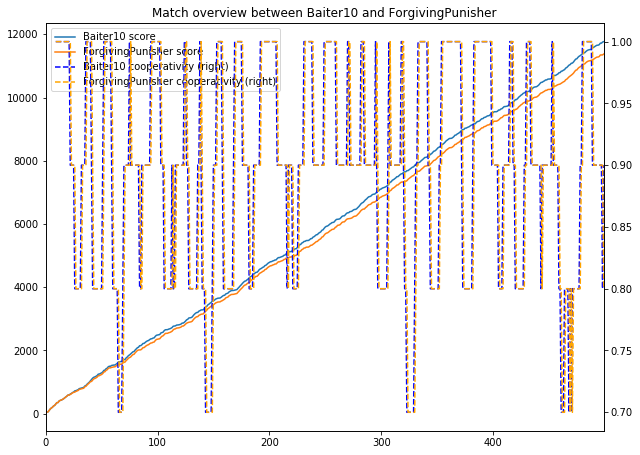

In [929]:
x = Interact(Baiter10, ForgivingPunisher, 500, verbose = 1, vis = 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Interaction series no 0. overview-------------------------
Baiter5 gained 11793.55 points (23.59 per game)
ForgivingPunisher gained 11302.04 points (22.6 per game)
Baiter5 cooperativity: 0.838
ForgivingPunisher cooperativity: 0.838


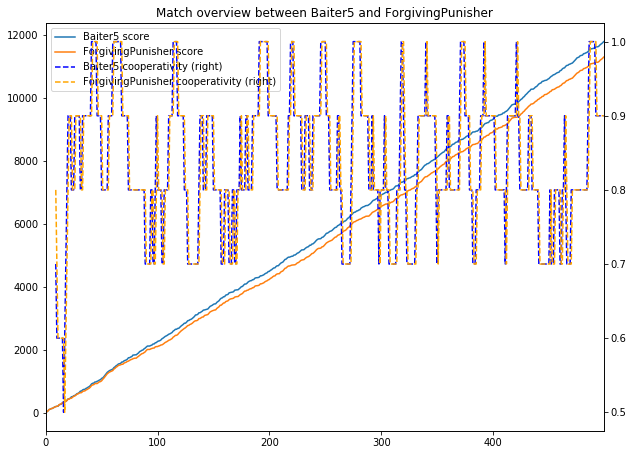

In [930]:
x = Interact(Baiter5, ForgivingPunisher, 500, verbose = 1, vis = 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Interaction series no 0. overview-------------------------
Baiter3 gained 10177.3 points (20.35 per game)
ForgivingPunisher gained 9345.73 points (18.69 per game)
Baiter3 cooperativity: 0.658
ForgivingPunisher cooperativity: 0.66


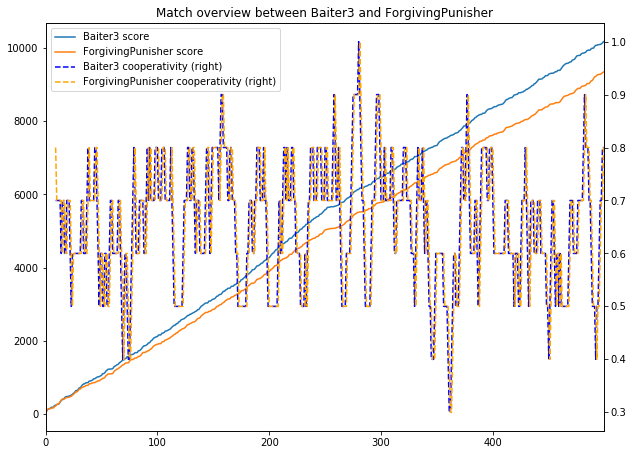

In [931]:
x = Interact(Baiter3, ForgivingPunisher, 500, verbose = 1, vis = 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Interaction series no 0. overview-------------------------
Baiter2 gained 9382.81 points (18.77 per game)
ForgivingPunisher gained 8616.48 points (17.23 per game)
Baiter2 cooperativity: 0.516
ForgivingPunisher cooperativity: 0.516


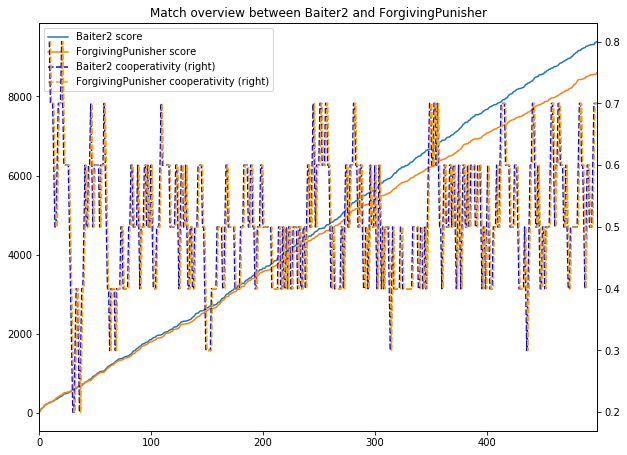

In [932]:
x = Interact(Baiter2, ForgivingPunisher, 500, verbose = 1, vis = 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Interaction series no 0. overview-------------------------
CorrelationWatcher4a gained 17774.78 points (17.77 per game)
CorrelationWatcher4b gained 17798.63 points (17.8 per game)
CorrelationWatcher4a cooperativity: 0.449
CorrelationWatcher4b cooperativity: 0.43


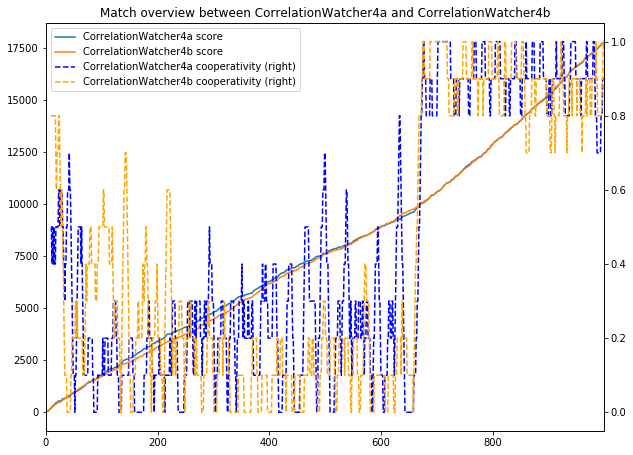

In [934]:
x = Interact(CorrelationWatcher4a, CorrelationWatcher4b, 1000, verbose = 1, vis = 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Interaction series no 0. overview-------------------------
CorrelationWatcher4a gained 8298.44 points (16.6 per game)
CorrelationWatcher3 gained 7689.84 points (15.38 per game)
CorrelationWatcher4a cooperativity: 0.248
CorrelationWatcher3 cooperativity: 0.322


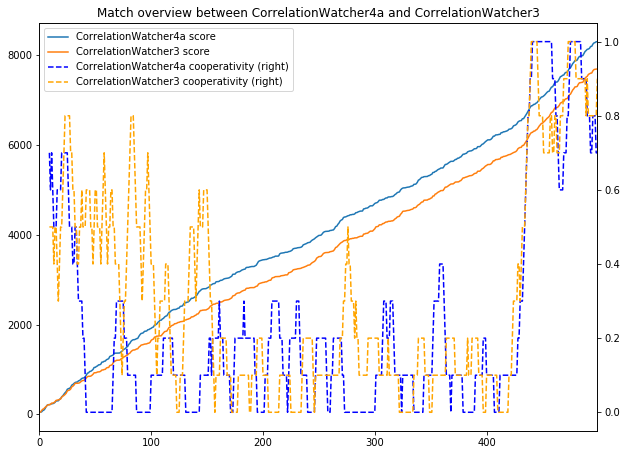

In [878]:
x = Interact(CorrelationWatcher4a, CorrelationWatcher3, 500, verbose = 1, vis = 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Interaction series no 0. overview-------------------------
CorrelationWatcher2 gained 9970.89 points (19.94 per game)
CorrelationWatcher3 gained 7294.09 points (14.59 per game)
CorrelationWatcher2 cooperativity: 0.158
CorrelationWatcher3 cooperativity: 0.596


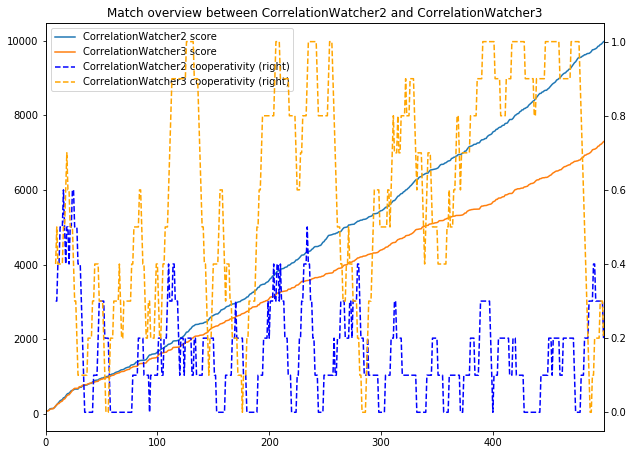

In [890]:
x = Interact(CorrelationWatcher2, CorrelationWatcher3, 500, verbose = 1, vis = 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Interaction series no 0. overview-------------------------
CorrelationWatcher1 gained 9593.5 points (19.19 per game)
CorrelationWatcher2 gained 10416.17 points (20.83 per game)
CorrelationWatcher1 cooperativity: 0.62
CorrelationWatcher2 cooperativity: 0.524


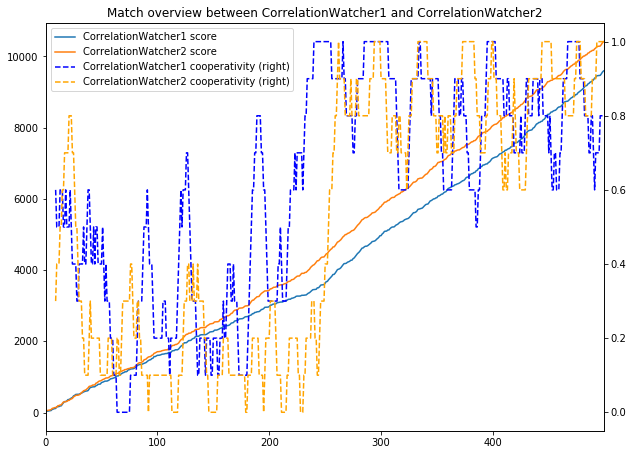

In [880]:
x = Interact(CorrelationWatcher1, CorrelationWatcher2, 500, verbose = 1, vis = 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Interaction series no 0. overview-------------------------
CorrelationWatcher5 gained 11948.51 points (23.9 per game)
ForgivingPunisher gained 11960.99 points (23.92 per game)
CorrelationWatcher5 cooperativity: 0.86
ForgivingPunisher cooperativity: 0.86


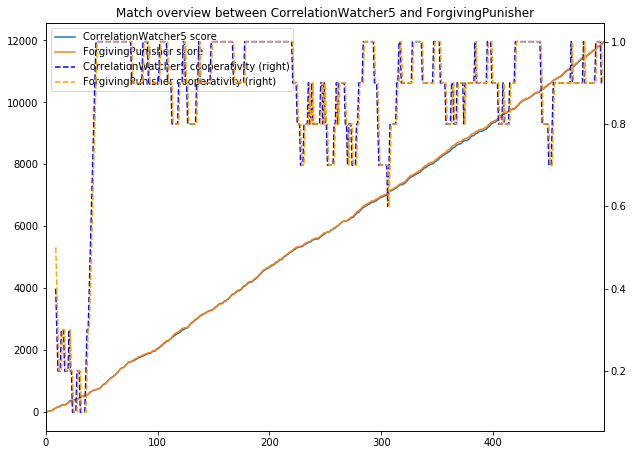

In [881]:
x = Interact(CorrelationWatcher5, ForgivingPunisher, 500, verbose = 1, vis = 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Interaction series no 0. overview-------------------------
CorrelationWatcher4 gained 8128.63 points (16.26 per game)
DesertionCalculator gained 8931.37 points (17.86 per game)
CorrelationWatcher4 cooperativity: 0.482
DesertionCalculator cooperativity: 0.48


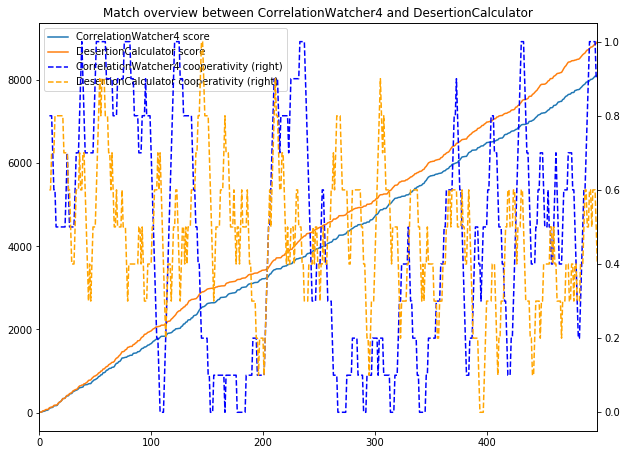

In [882]:
x = Interact(CorrelationWatcher4, DesertionCalculator, 500, verbose = 1, vis = 1)

Interaction series no 0. overview-------------------------
BlindDeserter gained 589.35 points (11.79 per game)
ForgivingPunisher gained 584.06 points (11.68 per game)
BlindDeserter cooperativity: 0.0
ForgivingPunisher cooperativity: 0.02


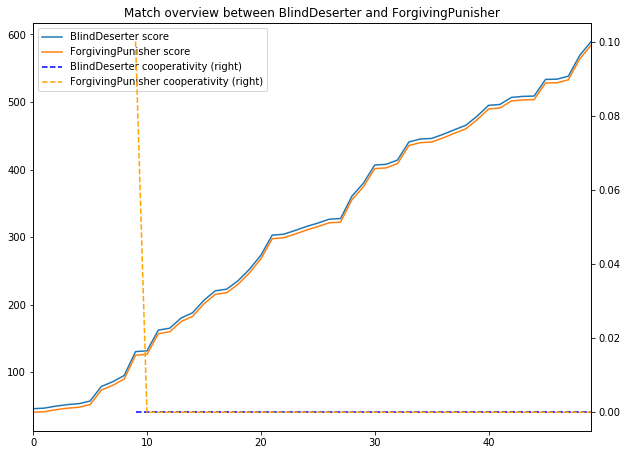

In [883]:
x = Interact(BlindDeserter, ForgivingPunisher, 50, verbose = 1, vis = 1)

Interaction series no 0. overview-------------------------
BlindCooperator gained 1139.81 points (22.8 per game)
ForgivingPunisher gained 1139.81 points (22.8 per game)
BlindCooperator cooperativity: 1.0
ForgivingPunisher cooperativity: 1.0


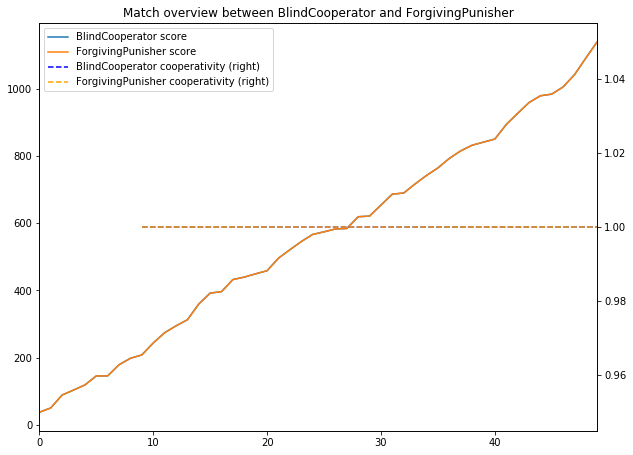

In [902]:
x = Interact(BlindCooperator, ForgivingPunisher, 50, verbose = 1, vis = 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:5277: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


Interaction series no 0. overview-------------------------
BlindCooperator gained 1554.86 points (15.55 per game)
CorrelationWatcher2 gained 2543.48 points (25.43 per game)
BlindCooperator cooperativity: 1.0
CorrelationWatcher2 cooperativity: 0.19


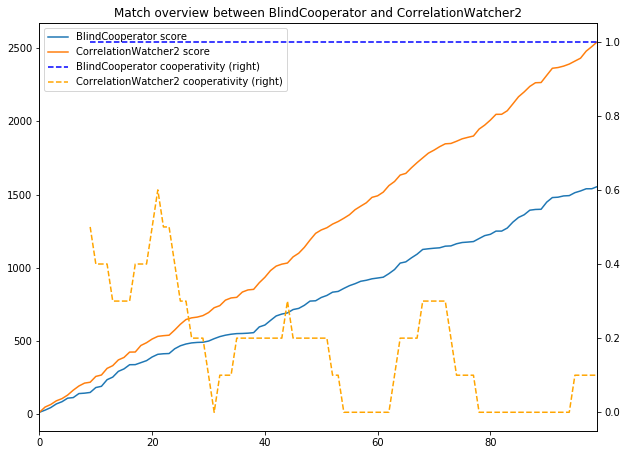

In [885]:
x = Interact(BlindCooperator, CorrelationWatcher2, 100, verbose = 1, vis = 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Interaction series no 0. overview-------------------------
Baiter5 gained 7731.06 points (15.46 per game)
CorrelationWatcher3 gained 10800.7 points (21.6 per game)
Baiter5 cooperativity: 0.8
CorrelationWatcher3 cooperativity: 0.198


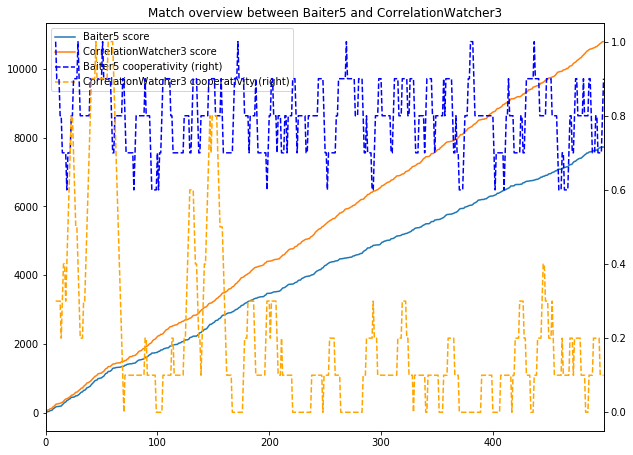

In [937]:
x = Interact(Baiter5, CorrelationWatcher3, 500, verbose = 1, vis = 1)